In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor
)
from sklearn.linear_model import (
    ElasticNet,
    Lasso,
    Ridge,
    LassoLars
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [2]:
# load the csv file
df = pd.read_csv('./data.csv')
df.head()

,Number,Extractant,Extractant Name,Phenyl Rings,Upper Rim,Lower Rim,Methylene Bridge,Extracted Name,Extractant Conc,Extracted Conc,Spectator Ions,Chemical Groups,Acid Molarity,Extraction Efficiency
0,1,TOPO,NaN,NaN,NaN,NaN,NaN,Th(IV),0.0001,0.0001,"NO3(2-), dichloromethane, H2O",NaN,1M HNO3,0.0
1,2,TOPO,NaN,NaN,NaN,NaN,NaN,Th(IV),0.0005,0.0001,"NO3(2-), dichloromethane, H2O",NaN,1M HNO3,0.0
2,3,TOPO,NaN,NaN,NaN,NaN,NaN,Th(IV),0.0010,0.0001,"NO3(2-), dichloromethane, H2O",NaN,1M HNO3,0.0
3,4,TOPO,NaN,NaN,NaN,NaN,NaN,Th(IV),0.0050,0.0001,"NO3(2-), dichloromethane, H2O",NaN,1M HNO3,1.4
4,5,TOPO,NaN,NaN,NaN,NaN,NaN,Th(IV),0.0100,0.0001,"NO3(2-), dichloromethane, H2O",NaN,1M HNO3,10.2


In [3]:
df_new = df.copy()
df_new = df_new.drop(['Number','Extractant Name'],axis=1)
df_new = df_new.fillna('none')

categorical_features = ['Extractant', 'Upper Rim', 'Lower Rim', 'Methylene Bridge', 
						'Extracted Name', 'Spectator Ions', 'Chemical Groups', 'Acid Molarity']
numerical_features = ['Phenyl Rings', 'Extractant Conc', 'Extracted Conc']

label_encoders = {}

# handle categorical features
for feature in categorical_features:
	le = LabelEncoder()
	if feature not in label_encoders:
		label_encoders[feature] = le
		df_new[feature] = le.fit_transform(df_new[feature])
	else:
		# handle unseen categories during prediction
		new_categories = set(df_new[feature]) - set(label_encoders[feature].classes_)
		if new_categories:
			df_new[feature] = df_new[feature].replace(list(new_categories), 'none')
		df_new[feature] = label_encoders[feature].transform(df_new[feature])

# handle numerical features
for feature in numerical_features:
	# here replace none to 0
	df_new[feature] = df_new[feature].replace('none', 0)
	df_new[feature] = pd.to_numeric(df_new[feature], errors='coerce')

# Normalize the specified numerical features individually between 0 and 1
for feature in ['Extractant Conc', 'Extracted Conc']:
	min_val = df_new[feature].min()
	max_val = df_new[feature].max()
	df_new[feature] = (df_new[feature] - min_val) / (max_val - min_val)
	# round to 6 decimals
	df_new[feature] = df_new[feature].round(6)

df_new.head()

# save the preprocessed data
df_new.to_csv('./data_new.csv', index=False)

In [4]:
def prepare_data(df, val_size=0.2, random_state=42):
    """
    Prepare training, validation, and test datasets
    Test set: Rows where Extraction Efficiency is 0
    Validation set: Portion of remaining data
    Training set: Remaining data
    """
    # Split into test and non-test data
    test_mask = df['Extraction Efficiency'] == 'none'
    test_df = df[test_mask].copy()
    train_val_df = df[~test_mask].copy()
    
    # Split remaining data into train and validation
    X_train_val = train_val_df.drop('Extraction Efficiency', axis=1)
    y_train_val = train_val_df['Extraction Efficiency'].astype(float) / 100
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, 
        test_size=val_size, 
        random_state=random_state
    )
    
    # Prepare test set
    X_test = test_df.drop('Extraction Efficiency', axis=1)
    y_test = test_df['Extraction Efficiency']
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_new)

In [5]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(224, 11) (57, 11) (29, 11)
(224,) (57,) (29,)


In [6]:
print('train x')
print(X_train[:5])
print('train y')
print(y_train[:5])

train x
     Extractant  Phenyl Rings  Upper Rim  Lower Rim  Methylene Bridge  \
165          22           4.0          9          7                 0   
212          23           0.0          7         13                 2   
5            24           0.0          7         13                 2   
152          22           4.0          9          7                 2   
266           2           4.0          9          3                 1   

     Extracted Name  Extractant Conc  Extracted Conc  Spectator Ions  \
165              18         0.099640        0.037806               0   
212              20         0.039616        0.037806               0   
5                20         0.099640        0.037806               0   
152              10         0.099640        0.037806               0   
266               7         0.000600        0.097943               3   

     Chemical Groups  Acid Molarity  
165               45             39  
212               45             39  
5     

In [7]:
def analyze_high_efficiency(df, efficiency_threshold=75):
    """Analyze patterns in high-efficiency extractions"""
    # Convert efficiency to numeric
    df['Efficiency_Numeric'] = pd.to_numeric(df['Extraction Efficiency'].replace('none', np.nan), errors='coerce')
    
    # Get threshold value
    threshold = np.percentile(df['Efficiency_Numeric'].dropna(), efficiency_threshold)
    high_eff_df = df[df['Efficiency_Numeric'] >= threshold].copy()
    
    print(f"Analysis of high efficiency cases (>{threshold:.1f}%):")
    
    # Analyze common patterns
    print("Most common extractants in high efficiency cases:")
    print(high_eff_df['Extractant'].value_counts().head())
    
    print("Most common upper rim modifications:")
    print(high_eff_df['Upper Rim'].value_counts().head())
    
    print("Concentration statistics:")
    print(high_eff_df['Extractant Conc'].describe())
    
    return high_eff_df

# Run the analysis
high_eff_df = analyze_high_efficiency(df)

Analysis of high efficiency cases (>46.9%):
Most common extractants in high efficiency cases:
Extractant
1b    7
1c    6
1e    6
1f    6
2b    5
Name: count, dtype: int64
Most common upper rim modifications:
Upper Rim
t-butyl    28
H          17
C18H37      4
C10H21      2
C12H25      2
Name: count, dtype: int64
Concentration statistics:
count    71.000000
mean      0.011488
std       0.030396
min       0.000100
25%       0.001000
50%       0.002500
75%       0.017500
max       0.250000
Name: Extractant Conc, dtype: float64


In [8]:
def try_multiple_models(X_train, X_val, y_train, y_val):
    # Dictionary to store results
    results = {}
    
    # 1. Random Forest
    rf = RandomForestRegressor(random_state=42)
    rf_params = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
    rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='r2')
    rf_grid.fit(X_train, y_train)
    rf_pred = rf_grid.predict(X_val)
    results['Random Forest'] = {
        'model': rf_grid,
        'r2': r2_score(y_val, rf_pred),
        'mae': mean_absolute_error(y_val, rf_pred),
        'best_params': rf_grid.best_params_
    }

    # 2. Gradient Boosting
    gb = GradientBoostingRegressor(random_state=42)
    gb_params = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    }
    gb_grid = GridSearchCV(gb, gb_params, cv=5, scoring='r2')
    gb_grid.fit(X_train, y_train)
    gb_pred = gb_grid.predict(X_val)
    results['Gradient Boosting'] = {
        'model': gb_grid,
        'r2': r2_score(y_val, gb_pred),
        'mae': mean_absolute_error(y_val, gb_pred),
        'best_params': gb_grid.best_params_
    }

    # 3. XGBoost
    xgb_model = xgb.XGBRegressor(random_state=42)
    xgb_params = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    }
    xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='r2')
    xgb_grid.fit(X_train, y_train)
    xgb_pred = xgb_grid.predict(X_val)
    results['XGBoost'] = {
        'model': xgb_grid,
        'r2': r2_score(y_val, xgb_pred),
        'mae': mean_absolute_error(y_val, xgb_pred),
        'best_params': xgb_grid.best_params_
    }
    
	# 4. Support Vector Regression
    svr = SVR(kernel='rbf')
    svr_params = {
        'C': [1.0, 10.0],
		'epsilon': [0.1, 0.2]
	}
    svr_grid = GridSearchCV(svr, svr_params, cv=5, scoring='r2')
    svr_grid.fit(X_train, y_train)
    svr_pred = svr_grid.predict(X_val)
    results['Support Vector Regression'] = {
        'model': svr_grid,
		'r2': r2_score(y_val, svr_pred),
		'mae': mean_absolute_error(y_val, svr_pred),
		'best_params': svr_grid.best_params_
	}
    
	# 5. Extra Trees
    et_params = {
        'n_estimators': [100, 200],
		'max_depth': [None, 10, 20],
		'min_samples_split': [2, 5]
	}
    et_grid = GridSearchCV(ExtraTreesRegressor(random_state=42), et_params, cv=5, scoring='r2')
    et_grid.fit(X_train, y_train)
    results['Extra Trees'] = {
        'model': et_grid,
        'r2': r2_score(y_val, et_grid.predict(X_val)),
        'mae': mean_absolute_error(y_val, et_grid.predict(X_val)),
        'best_params': et_grid.best_params_
    }
    
	# 6. AdaBoost
    ada_params = {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'loss': ['linear', 'square', 'exponential']
    }
    ada_grid = GridSearchCV(AdaBoostRegressor(random_state=42), ada_params, cv=5, scoring='r2')
    ada_grid.fit(X_train, y_train)
    results['AdaBoost'] = {
        'model': ada_grid,
        'r2': r2_score(y_val, ada_grid.predict(X_val)),
        'mae': mean_absolute_error(y_val, ada_grid.predict(X_val)),
        'best_params': ada_grid.best_params_
    }
    
	# 7. Hist Gradient Boosting
    hgb_params = {
        'max_iter': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    }
    hgb_grid = GridSearchCV(HistGradientBoostingRegressor(random_state=42), hgb_params, cv=5, scoring='r2')
    hgb_grid.fit(X_train, y_train)
    results['Histogram GBM'] = {
        'model': hgb_grid,
        'r2': r2_score(y_val, hgb_grid.predict(X_val)),
        'mae': mean_absolute_error(y_val, hgb_grid.predict(X_val)),
        'best_params': hgb_grid.best_params_
    }
    
	# 8. Elastic Net
    enet_params = {
        'alpha': [0.1, 1.0],
    }
    enet_grid = GridSearchCV(ElasticNet(random_state=42), enet_params, cv=5, scoring='r2')
    enet_grid.fit(X_train, y_train)  # Note: using scaled features
    results['Elastic Net'] = {
        'model': enet_grid,
        'r2': r2_score(y_val, enet_grid.predict(X_val)),
        'mae': mean_absolute_error(y_val, enet_grid.predict(X_val)),
        'best_params': enet_grid.best_params_
    }
    
	# 9. MLP
    mlp_params = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['adaptive']
    }
    mlp_grid = GridSearchCV(MLPRegressor(random_state=42, max_iter=1000), mlp_params, cv=5, scoring='r2')
    mlp_grid.fit(X_train, y_train)  # Note: using scaled features
    results['Neural Network'] = {
        'model': mlp_grid,
        'r2': r2_score(y_val, mlp_grid.predict(X_val)),
        'mae': mean_absolute_error(y_val, mlp_grid.predict(X_val)),
        'best_params': mlp_grid.best_params_
    }
    
	# 10. Kernel Ridge
    kr_params = {
        'alpha': [0.1, 1.0],
        'kernel': ['rbf', 'polynomial'],
        'degree': [2, 3]  # for polynomial kernel
    }
    kr_grid = GridSearchCV(KernelRidge(), kr_params, cv=5, scoring='r2')
    kr_grid.fit(X_train, y_train)  # Note: using scaled features
    results['Kernel Ridge'] = {
        'model': kr_grid,
        'r2': r2_score(y_val, kr_grid.predict(X_val)),
        'mae': mean_absolute_error(y_val, kr_grid.predict(X_val)),
        'best_params': kr_grid.best_params_
    }
    
	# 11. KNN
    knn_params = {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }
    knn_grid = GridSearchCV(KNeighborsRegressor(), knn_params, cv=5, scoring='r2')
    knn_grid.fit(X_train, y_train)  # Note: using scaled features
    results['KNN'] = {
        'model': knn_grid,
        'r2': r2_score(y_val, knn_grid.predict(X_val)),
        'mae': mean_absolute_error(y_val, knn_grid.predict(X_val)),
        'best_params': knn_grid.best_params_
    }

	# 12. Decision Tree Regressor
    dt_params = {
		'max_depth': [None, 10, 20],
		'min_samples_split': [2, 5]
	}
    dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=5, scoring='r2')
    dt_grid.fit(X_train, y_train)
    results['Decision Tree'] = {
		'model': dt_grid,
		'r2': r2_score(y_val, dt_grid.predict(X_val)),
		'mae': mean_absolute_error(y_val, dt_grid.predict(X_val)),
		'best_params': dt_grid.best_params_
	}
    
	# 13. Lasso
    lasso_params = {
		'alpha': [0.1, 1.0]
	}
    lasso_grid = GridSearchCV(Lasso(random_state=42), lasso_params, cv=5, scoring='r2')
    lasso_grid.fit(X_train, y_train)
    results['Lasso'] = {
		'model': lasso_grid,
		'r2': r2_score(y_val, lasso_grid.predict(X_val)),
		'mae': mean_absolute_error(y_val, lasso_grid.predict(X_val)),
		'best_params': lasso_grid.best_params_
	}
    
	# 14. Lasso Lars
    lars_params = {
		'alpha': [0.1, 1.0]
	}
    lars_grid = GridSearchCV(LassoLars(), lars_params, cv=5, scoring='r2')
    lars_grid.fit(X_train, y_train)
    results['Lasso Lars'] = {
		'model': lars_grid,
		'r2': r2_score(y_val, lars_grid.predict(X_val)),
		'mae': mean_absolute_error(y_val, lars_grid.predict(X_val)),
		'best_params': lars_grid.best_params_
	}
    
	# 15. Ridge
    ridge_params = {
		'alpha': [0.1, 1.0]
	}
    ridge_grid = GridSearchCV(Ridge(random_state=42), ridge_params, cv=5, scoring='r2')
    ridge_grid.fit(X_train, y_train)
    results['Ridge'] = {
		'model': ridge_grid,
		'r2': r2_score(y_val, ridge_grid.predict(X_val)),
		'mae': mean_absolute_error(y_val, ridge_grid.predict(X_val)),
		'best_params': ridge_grid.best_params_
	}

    return results

# Function to analyze feature interactions
def analyze_feature_interactions(model, X_train, feature_names):
    # Get feature importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        return None
        
    # Get top 5 important features
    top_features_idx = np.argsort(importances)[-5:]
    top_features = feature_names[top_features_idx]
    
    interactions = []
    for i in range(len(top_features)):
        for j in range(i+1, len(top_features)):
            feat1, feat2 = top_features[i], top_features[j]
            correlation = np.corrcoef(X_train[feat1], X_train[feat2])[0,1]
            interactions.append({
                'features': (feat1, feat2),
                'correlation': correlation
            })
    
    return pd.DataFrame(interactions)

results = try_multiple_models(X_train, X_val, y_train, y_val)
print("\nModel Comparison Results:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"R² Score: {metrics['r2']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print("Best Parameters:", metrics['best_params'])

c:\Users\shour\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\shour\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(



Model Comparison Results:

Random Forest:
R² Score: 0.7835
MAE: 0.1025
Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

Gradient Boosting:
R² Score: 0.7990
MAE: 0.1015
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

XGBoost:
R² Score: 0.8316
MAE: 0.0872
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

Support Vector Regression:
R² Score: 0.2445
MAE: 0.2118
Best Parameters: {'C': 10.0, 'epsilon': 0.1}

Extra Trees:
R² Score: 0.8147
MAE: 0.0887
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}

AdaBoost:
R² Score: 0.5961
MAE: 0.1580
Best Parameters: {'learning_rate': 0.1, 'loss': 'square', 'n_estimators': 50}

Histogram GBM:
R² Score: 0.6843
MAE: 0.1325
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_iter': 200}

Elastic Net:
R² Score: 0.1972
MAE: 0.2280
Best Parameters: {'alpha': 0.1}

Neural Network:
R² Score: 0.3532
MAE: 0.2148
Best Parameters: {'alp


Feature Importance Summary Across Models:
         Feature  Random Forest_importance  Gradient Boosting_importance  XGBoost_importance  Support Vector Regression_importance  Extra Trees_importance  AdaBoost_importance  Histogram GBM_importance  Elastic Net_importance  Neural Network_importance  Kernel Ridge_importance  KNN_importance  Decision Tree_importance  Lasso_importance  Lasso Lars_importance  Ridge_importance
      Extractant                  0.503720                      0.902861            0.835440                              0.175419                0.526875             0.233729                  0.618398                0.021197                   1.044913                 0.823267        0.809113                  0.840690          0.000000               0.000000          0.057725
    Phenyl Rings                  0.096287                      0.096714            0.105403                              0.008340                0.131052             0.033689                  0.0394

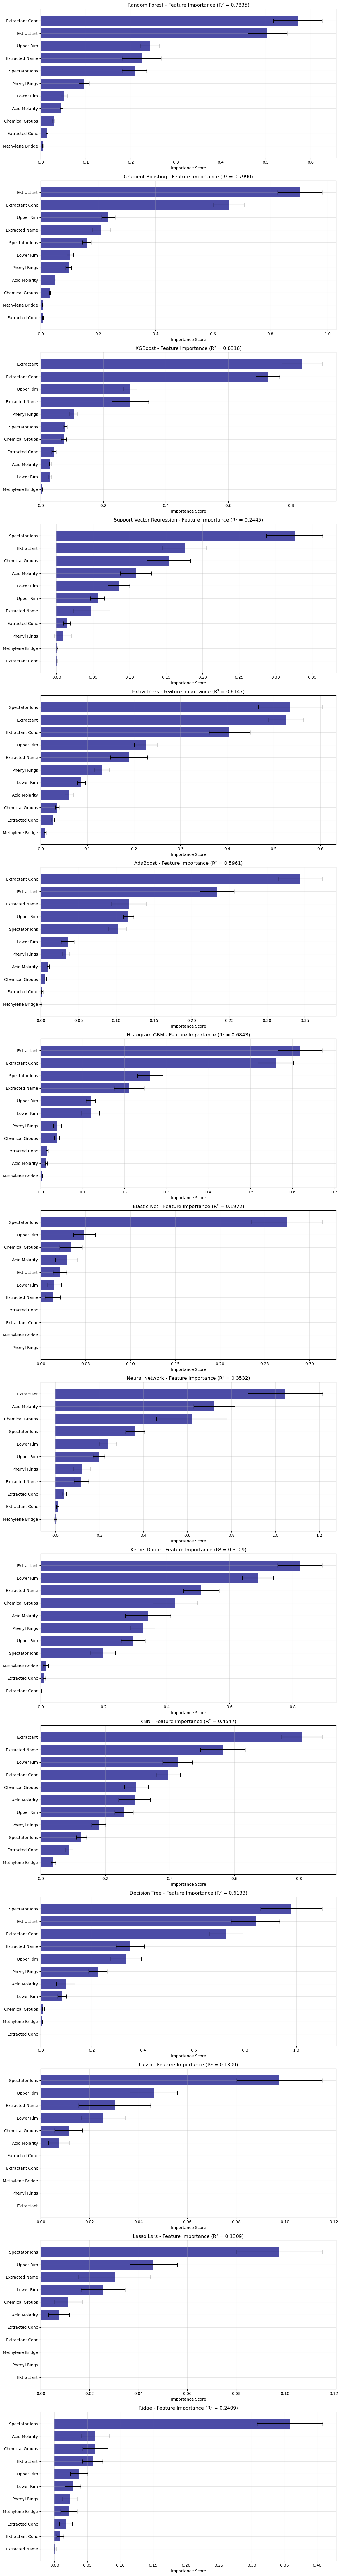

In [9]:
def analyze_all_models_feature_sensitivity(results, X_train, y_train, feature_names):
    """
    Analyze feature sensitivity for all models using permutation importance
    
    Parameters:
    -----------
    results : dict
        Dictionary containing all trained models and their metrics
    X_train : array-like
        Feature matrix
    y_train : array-like
        Target vector
    feature_names : array-like
        List of feature names
    """
    # Dictionary to store importance results for each model
    importance_results = {}
    
    # Calculate permutation importance for each model
    for model_name, model_dict in results.items():
        model = model_dict['model'].best_estimator_
        
        # Calculate permutation importance
        result = permutation_importance(
            model, X_train, y_train,
            n_repeats=10,
            random_state=42
        )
        
        # Store results
        importance_results[model_name] = {
            'importance': result.importances_mean,
            'std': result.importances_std
        }
    
    # Create a combined plot
    n_features = len(feature_names)
    n_models = len(results)
    
    fig, axes = plt.subplots(n_models, 1, figsize=(12, 6*n_models))
    
    # Plot for each model
    for idx, (model_name, importance_dict) in enumerate(importance_results.items()):
        ax = axes[idx] if n_models > 1 else axes
        
        # Sort features by importance
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance_dict['importance'],
            'std': importance_dict['std']
        }).sort_values('importance', ascending=True)  # Ascending for horizontal bar plot
        
        # Create horizontal bar plot
        ax.barh(range(n_features), importance_df['importance'],
                xerr=importance_df['std'], 
                capsize=5,
                alpha=0.7,
                color='navy')
        
        ax.set_yticks(range(n_features))
        ax.set_yticklabels(importance_df['feature'])
        ax.set_xlabel('Importance Score')
        ax.set_title(f'{model_name} - Feature Importance (R² = {results[model_name]["r2"]:.4f})')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Create a summary DataFrame
    summary_data = []
    for feature in feature_names:
        feature_data = {'Feature': feature}
        for model_name in results.keys():
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importance_results[model_name]['importance']
            })
            feature_data[f'{model_name}_importance'] = importance_df[
                importance_df['feature'] == feature
            ]['importance'].values[0]
        summary_data.append(feature_data)
    
    summary_df = pd.DataFrame(summary_data)
    
    # Print summary table
    print("\nFeature Importance Summary Across Models:")
    print(summary_df.to_string(index=False))
    
    return summary_df, importance_results

# Run the analysis for all models
summary_df, importance_results = analyze_all_models_feature_sensitivity(
    results, X_train, y_train, X_train.columns
)

# Print the top 5 most important features for each model
print("\nTop 5 Most Important Features by Model:")
for model_name in results.keys():
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importance_results[model_name]['importance']
    }).sort_values('importance', ascending=False)
    
    print(f"\n{model_name}:")
    print(importance_df.head().to_string(index=False))

In [10]:
# Function to print detailed results
def print_model_comparison(results):
    print("\nModel Comparison Results:")
    # Create a DataFrame for easy comparison
    comparison_df = pd.DataFrame({
        'Model': [],
        'R² Score': [],
        'MAE': [],
        'Best Parameters': []
    })
    
    for model_name, metrics in results.items():
        new_row = pd.DataFrame({
            'Model': [model_name],
            'R² Score': [metrics['r2']],
            'MAE': [metrics['mae']],
            'Best Parameters': [str(metrics['best_params'])]
        })
        comparison_df = pd.concat([comparison_df, new_row], ignore_index=True)
    
    # Sort by R² score descending
    comparison_df = comparison_df.sort_values('R² Score', ascending=False)
    
    # Print formatted results
    print("\nModel Performance Summary:")
    print(comparison_df.to_string(index=False))
    
    # Print top 3 models
    print("\nTop 3 Performing Models:")
    print(comparison_df.head(3).to_string(index=False))
    
print_model_comparison(results)


Model Comparison Results:

Model Performance Summary:
                    Model  R² Score      MAE                                                              Best Parameters
                  XGBoost  0.831564 0.087152                  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
              Extra Trees  0.814742 0.088749             {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
        Gradient Boosting  0.799010 0.101523                  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
            Random Forest  0.783520 0.102477               {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
            Histogram GBM  0.684309 0.132454                      {'learning_rate': 0.1, 'max_depth': 5, 'max_iter': 200}
            Decision Tree  0.613286 0.101581                                  {'max_depth': None, 'min_samples_split': 5}
                 AdaBoost  0.596137 0.158015                 {'learning_rate': 0.1, 'loss':